In [1]:
from fastai.tabular.all import *
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Data Collection

In [2]:
df = pd.read_csv('winequality-white.csv', sep=';', low_memory=False)

# Viewing Data

In [3]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,...,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,...,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,...,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,...,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,...,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,...,3.19,0.40,9.9,6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,...,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,...,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,...,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,...,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,...,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,...,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,...,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,...,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,...,3.820000,1.080000,14.200000,9.000000


In [7]:
df_reg = df.copy()
df_class = df.copy()

In [8]:
cont = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

In [9]:
dep_var = 'quality'

In [10]:
df_reg[dep_var] = np.log(df_reg[dep_var])

# Train model on data first time

In [11]:
procs = [Normalize]

In [12]:
splits = RandomSplitter(valid_pct=0.3)(range_of(df_reg))

In [13]:
#cont,cat = cont_cat_split(df_reg, 0.01, dep_var=dep_var)

In [14]:
to = TabularPandas(df_reg, procs, cont, y_names=dep_var, splits=splits)

In [15]:
len(to.train), len(to.valid)

(3429, 1469)

In [16]:
to.show()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3424,6.4,0.32,0.27,4.90,0.034,18.0,122.0,0.99160,3.36,0.71,12.5,1.791759
2270,7.3,0.19,0.25,1.40,0.051,41.0,107.0,0.99382,3.53,0.66,10.5,1.945910
4884,6.5,0.33,0.38,8.30,0.048,68.0,174.0,0.99492,3.14,0.50,9.6,1.609438
3192,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,1.791759
4740,6.0,0.32,0.46,1.50,0.050,56.0,189.0,0.99308,3.24,0.49,9.6,1.609438
4521,6.3,0.36,0.20,2.00,0.048,48.0,191.0,0.99290,3.17,0.51,9.6,1.609438
4782,6.7,0.30,0.50,12.10,0.045,38.0,127.0,0.99740,3.04,0.53,8.9,1.791759
2010,7.0,0.25,0.56,2.00,0.035,20.0,95.0,0.99180,3.23,0.53,11.0,1.791759
2779,6.7,0.20,0.37,1.65,0.025,42.0,103.0,0.99022,3.11,0.45,11.4,1.609438
2439,7.3,0.27,0.37,9.70,0.042,36.0,130.0,0.99790,3.48,0.75,9.9,1.791759


In [17]:
save_pickle('to.pkl',to)

In [18]:
to = load_pickle('to.pkl')

In [19]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [20]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y);

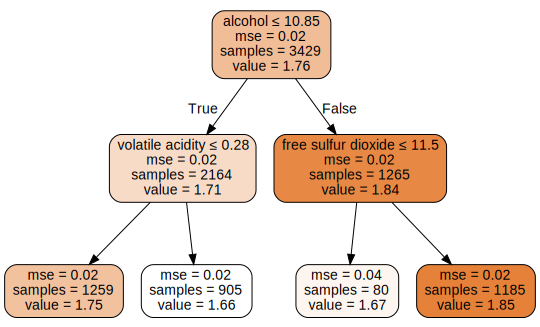

In [21]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

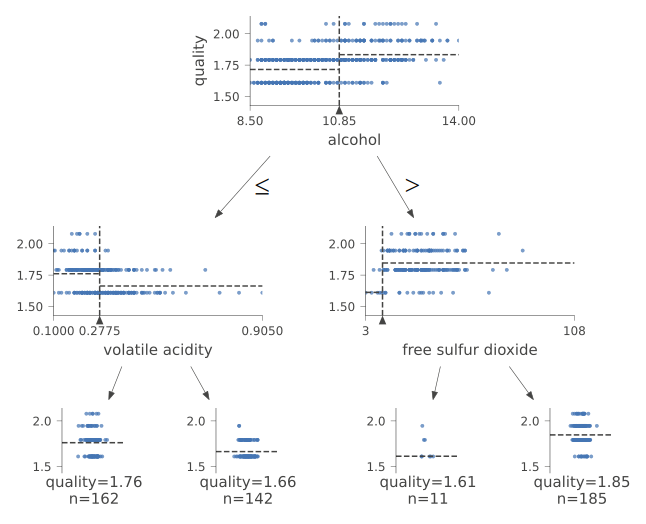

In [22]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=2, label_fontsize=10)

In [23]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [24]:
m.score(xs, y)

1.0

In [25]:
m.score(valid_xs, valid_y)

0.1316278720762214

In [26]:
m.get_n_leaves(), len(xs)

(971, 3429)

In [27]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(to.train.xs, to.train.y)
m.score(xs, y), m.score(valid_xs, valid_y)

(0.6147688840329246, 0.2793263137450285)

In [28]:
m.get_n_leaves()

265

In [29]:
def rf(xs, y, n_estimators=400,
       max_features=0.5, min_samples_leaf=10, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [30]:
m = rf(xs, y);

In [31]:
m.score(xs, y), m.score(valid_xs, valid_y)

(0.5997811870995031, 0.4237632037057475)

In [32]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [33]:
mean_squared_error(preds.mean(0), valid_y, squared=False)

0.11875373827577541

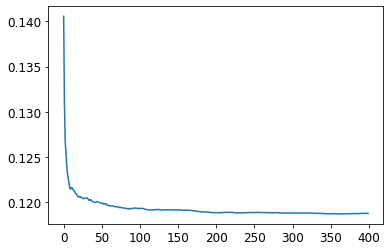

In [34]:
plt.plot([mean_squared_error(preds[:i+1].mean(0), valid_y, squared=False) for i in range(400)]);

In [35]:
mean_squared_error(m.oob_prediction_, y, squared=False)

0.11675053546515977

In [36]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [37]:
preds.shape

(400, 1469)

In [38]:
preds_std = preds.std(0)

In [39]:
preds_std[:5]

array([0.08184039, 0.07458014, 0.08123086, 0.07228939, 0.10348983])

# Data Preparation

In [40]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [41]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
10,alcohol,0.254519
1,volatile acidity,0.139434
5,free sulfur dioxide,0.120552
7,density,0.114191
4,chlorides,0.067269
3,residual sugar,0.064758
6,total sulfur dioxide,0.057373
2,citric acid,0.055602
8,pH,0.048006
0,fixed acidity,0.047141


In [42]:
def plot_fi(fi):
    return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)

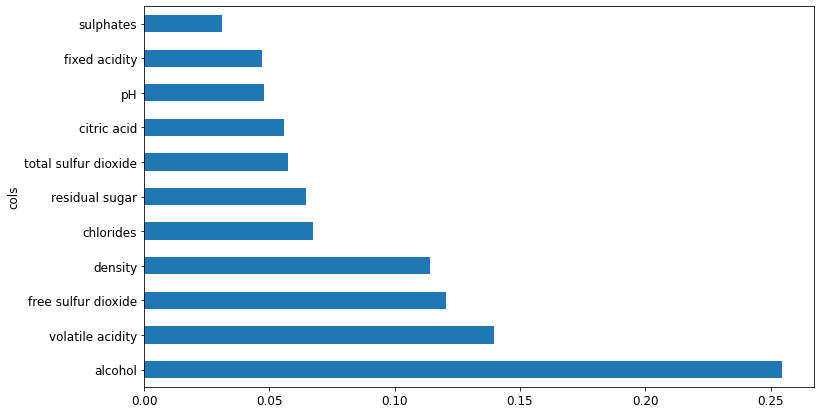

In [43]:
plot_fi(fi);

In [44]:
to_keep = fi[fi.imp>0.05].cols
len(to_keep)

8

In [45]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [46]:
m = rf(xs_imp, y)

In [47]:
m.score(xs_imp, y), m.score(valid_xs_imp, valid_y)

(0.5770746241883858, 0.40924591851242476)

In [48]:
len(xs.columns), len(xs_imp.columns)

(11, 8)

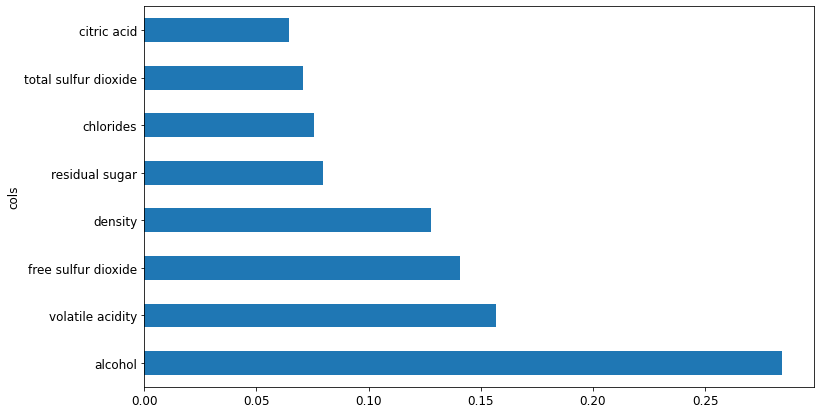

In [49]:
plot_fi(rf_feat_importance(m, xs_imp));

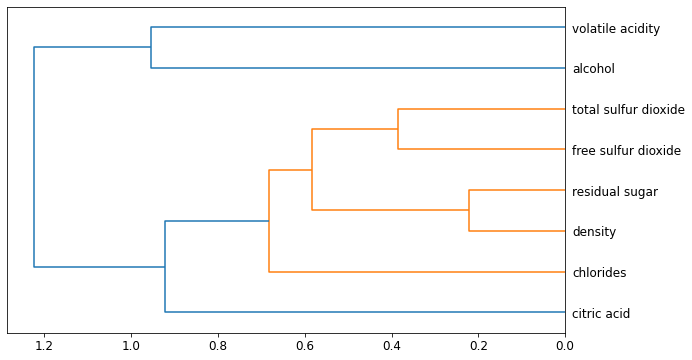

In [50]:
cluster_columns(xs_imp)

In [51]:
def get_oob(df_reg):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=80, oob_score=True)
    m.fit(df_reg, y)
    return m.oob_score_

In [52]:
get_oob(xs_imp)

0.466608141709664

In [53]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [54]:
save_pickle('xs_final.pkl', xs_final)
save_pickle('valid_xs_final.pkl', valid_xs_final)

In [55]:
xs_final = load_pickle('xs_final.pkl')
valid_xs_final = load_pickle('valid_xs_final.pkl')

In [56]:
m = rf(xs_final, y)
m.score(xs_final, y), m.score(valid_xs_final, valid_y)

(0.5780266462686896, 0.41068641798438)

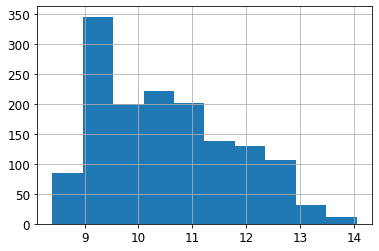

In [57]:
ax = valid_xs_final['alcohol'].hist()

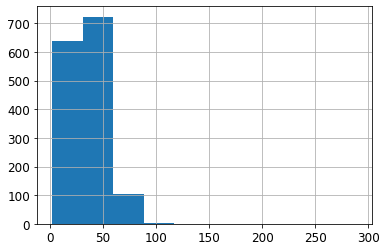

In [58]:
bx = valid_xs_final['free sulfur dioxide'].hist()

In [59]:
from sklearn.inspection import plot_partial_dependence

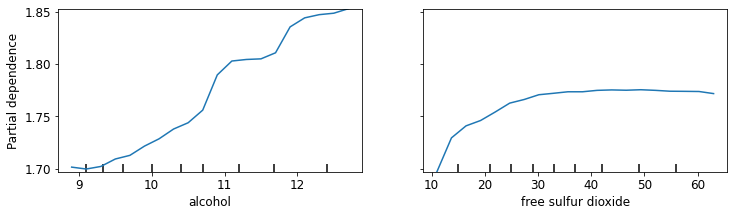

In [60]:
fig, ax = plt.subplots(figsize=(12, 3))
plot_partial_dependence(m, valid_xs_final, ['alcohol', 'free sulfur dioxide'], grid_resolution=20, ax=ax);

In [61]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [62]:
row = valid_xs_final.iloc[:5]

In [63]:
predictions,bias,contributions = treeinterpreter.predict(m, row.values)

In [64]:
predictions[0], bias[0], contributions[0].sum()

(array([1.55623078]), 1.7587508738017452, -0.20252009327485182)

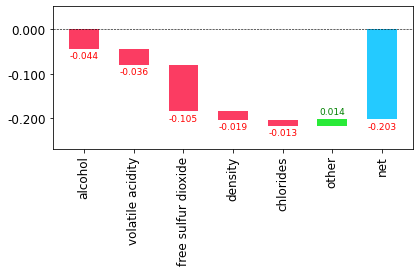

In [65]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
         rotation_value=90,formatting='{:,.3f}');

In [66]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

In [67]:
m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)

,cols,imp
3,density,0.154627
6,total sulfur dioxide,0.147191
5,residual sugar,0.129667
2,free sulfur dioxide,0.126862
4,chlorides,0.115841
1,volatile acidity,0.114801
7,citric acid,0.109275
0,alcohol,0.101736


In [68]:
m = rf(xs_final, y)
print('orig', m.score(valid_xs_final, valid_y))

for c in ('density','total sulfur dioxide','residual sugar','free sulfur dioxide'):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m.score(valid_xs_final.drop(c, axis=1), valid_y))

orig 0.4092751785502934
density 0.40031182901574647
total sulfur dioxide 0.39893324564350974
residual sugar 0.40090699021270826
free sulfur dioxide 0.37183297752374345


In [69]:
t_vars = ['density']
xs_final_t = xs_final.drop(t_vars, axis=1)
valid_xs_t = valid_xs_final.drop(t_vars, axis=1)

m = rf(xs_final_t, y)
m.score(valid_xs_t, valid_y)

0.40094831141459397

In [70]:
xs_filt = xs_final_t
y_filt = y

In [71]:
m = rf(xs_filt, y_filt)
m.score(xs_filt, y_filt), m.score(valid_xs_t, valid_y)

(0.5600800073527595, 0.4003915722573912)

# Train model on data second time

In [72]:
df_nn = pd.read_csv('winequality-white.csv', sep=';', low_memory=False)
df_nn[dep_var] = np.log(df_nn[dep_var])

In [73]:
df_nn_final = df_nn[list(xs_final_t.columns) + [dep_var]]

In [74]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [75]:
xs_filt2 = xs_filt
valid_xs_t2 = valid_xs_t
m2 = rf(xs_filt2, y_filt)
m2.score(xs_filt2, y_filt), m2.score(valid_xs_t2, valid_y)

(0.5594533457376565, 0.40044835069666873)

In [76]:
procs_nn = [Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cont_names = cont_nn, splits=splits, y_names=dep_var)

In [77]:
dls = to_nn.dataloaders(1024)

In [78]:
y = to_nn.train.y
y.min(), y.max()

(1.0986123, 2.1972246)

In [79]:
learn = tabular_learner(dls, y_range=(1.09,2.19), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.00363078061491251)

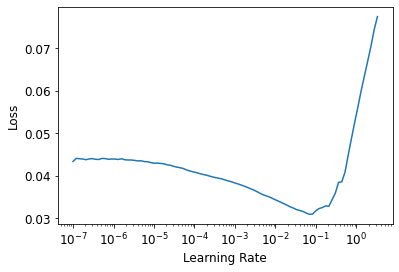

In [80]:
learn.lr_find()

In [81]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.044291,0.039143,00:00
1,0.059498,0.033121,00:00
2,0.051810,0.022483,00:00
3,0.044646,0.024558,00:00
4,0.038952,0.019180,00:00
5,0.034798,0.017169,00:00
6,0.031550,0.017151,00:00
7,0.029071,0.016403,00:00
8,0.027159,0.016135,00:00
9,0.025599,0.016083,00:00


In [82]:
preds,targs = learn.get_preds()
mean_squared_error(preds,targs, squared=False)

0.12681903

In [83]:
learn.save('nn')

Path('models/nn.pth')

In [84]:
rf_preds = m.predict(valid_xs_t)
ens_preds = (to_np(preds.squeeze()) + rf_preds) / 2

In [85]:
mean_squared_error(ens_preds, valid_y, squared=False)

0.12240675853248477

# Analysis/Evaluation

# Serve model

# Retrain model

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [87]:
dep_var_class = 'quality'

In [88]:
procs_class = [Categorify, Normalize]

In [89]:
splits_class = RandomSplitter(valid_pct=0.3)(range_of(df_class))

In [90]:
#cont_class,cat_class = cont_cat_split(df_class, 0.01, dep_var=dep_var_class)

In [91]:
to_class = TabularPandas(df, procs_class, cont, y_names=dep_var_class, splits=splits_class)

In [92]:
len(to_class.train), len(to_class.valid)

(3429, 1469)

In [93]:
to_class.show()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2171,7.4,0.19,0.3,12.8,0.053,48.5,229.0,0.9986,3.14,0.49,9.1,7
4751,7.3,0.36,0.62,7.1,0.033,48.0,185.0,0.99472,3.14,0.62,10.6,6
2594,5.4,0.5,0.13,5.0,0.028,12.0,107.0,0.99079,3.48,0.88,13.5,7
271,5.2,0.6,0.07,7.0,0.044,33.0,147.0,0.9944,3.33,0.58,9.7,5
3999,6.4,0.24,0.49,5.8,0.053,25.0,120.0,0.9942,3.01,0.98,10.5,6
4718,5.2,0.24,0.15,7.1,0.043,32.0,134.0,0.99378,3.24,0.48,9.9,6
192,6.8,0.28,0.36,8.0,0.045,28.0,123.0,0.9928,3.02,0.37,11.4,6
1715,6.5,0.18,0.34,1.6,0.04,43.0,148.0,0.9912,3.32,0.59,11.5,8
449,6.4,0.28,0.29,1.6,0.052,34.0,127.0,0.9929,3.48,0.56,10.5,7
1577,7.1,0.64,0.49,1.8,0.05,17.0,128.0,0.9946,3.31,0.58,10.6,4


In [94]:
xs_class, y_class = to_class.train.xs, to_class.train.y
valid_xs_class, valid_y_class = to_class.valid.xs, to_class.valid.y

In [95]:
m_class = DecisionTreeClassifier(max_leaf_nodes=4)
m_class.fit(xs_class,y_class);

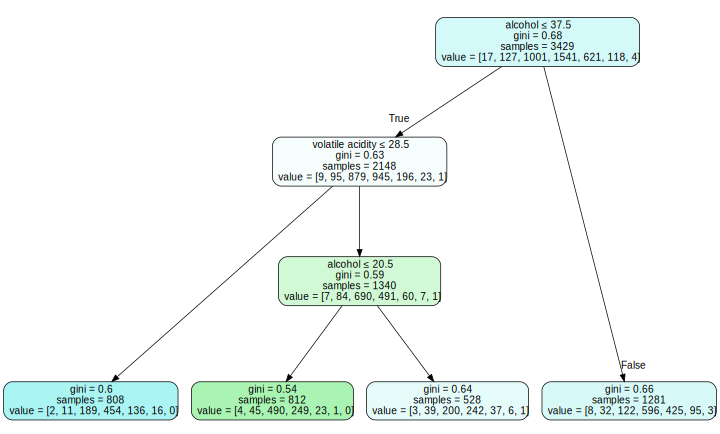

In [96]:
draw_tree(m_class, xs_class, size=10, leaves_parallel=True, precision=2)

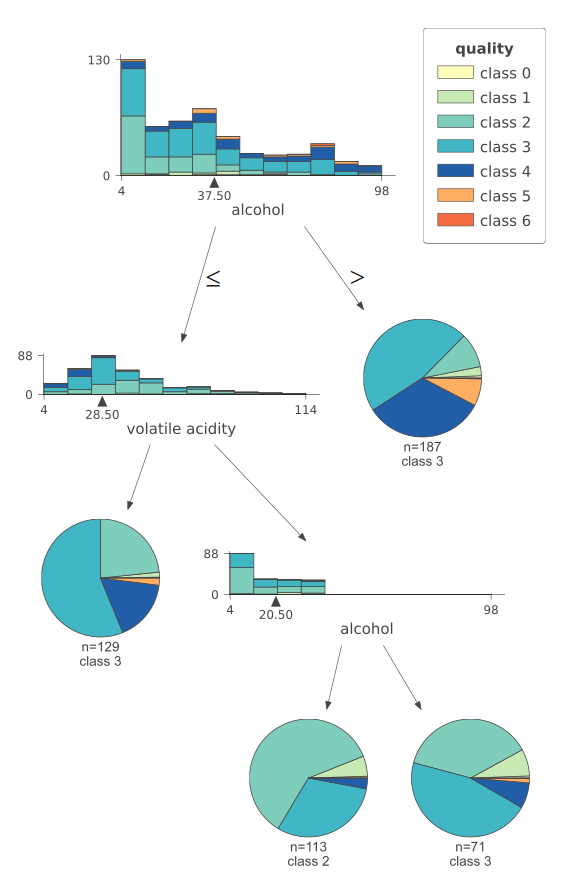

In [97]:
samp_idx_class = np.random.permutation(len(y_class))[:500]
dtreeviz(m_class, xs_class.iloc[samp_idx_class], y_class.iloc[samp_idx_class], xs_class.columns, dep_var_class,
        fontname='DejaVu Sans', scale=2, label_fontsize=10)

In [98]:
m_class = DecisionTreeClassifier()
m_class.fit(xs_class,y_class);

In [99]:
m_class.score(xs_class, y_class)

1.0

In [100]:
m_class.score(valid_xs_class, valid_y_class)

0.595643294758339

In [101]:
m_class.get_n_leaves(), len(xs_class)

(967, 3429)

In [102]:
m_class = DecisionTreeClassifier(min_samples_leaf=10)
m_class.fit(to_class.train.xs, to_class.train.y)
m_class.score(xs_class, y_class), m_class.score(valid_xs_class, valid_y_class)

(0.705161854768154, 0.5289312457454051)

In [103]:
m_class.get_n_leaves()

256

In [104]:
def rf_class(xs, y, n_estimators=400,
       max_features=0.5, min_samples_leaf=10, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [105]:
m_class = rf_class(xs_class,y_class);

In [106]:
m_class.score(xs_class, y_class), m_class.score(valid_xs_class, valid_y_class)

(0.7389909594634004, 0.6119809394145678)

In [107]:
preds_class = np.stack([t.predict(valid_xs_class) for t in m_class.estimators_])

In [108]:
accuracy_score(preds_class.argmax(0), valid_y_class)

0.012253233492171545

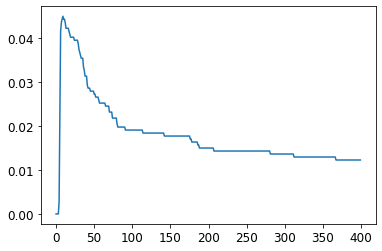

In [109]:
plt.plot([accuracy_score(preds_class[:i+1].argmax(0), valid_y_class) for i in range(400)]);

In [110]:
accuracy_score((m_class.oob_decision_function_).argmax(axis=-1), y_class)

0.0032079323417906094

In [111]:
preds_class = np.stack([t.predict(valid_xs_class) for t in m_class.estimators_])

In [112]:
preds_class.shape

(400, 1469)

In [113]:
preds_class_std = preds_class.std(0)

In [114]:
preds_std[:5]

array([0.08184039, 0.07458014, 0.08123086, 0.07228939, 0.10348983])

In [115]:
fi_class = rf_feat_importance(m_class, xs_class)
fi_class

,cols,imp
10,alcohol,0.189622
1,volatile acidity,0.127124
7,density,0.108427
5,free sulfur dioxide,0.090393
3,residual sugar,0.077147
6,total sulfur dioxide,0.075966
4,chlorides,0.074498
8,pH,0.071491
2,citric acid,0.068602
9,sulphates,0.062761


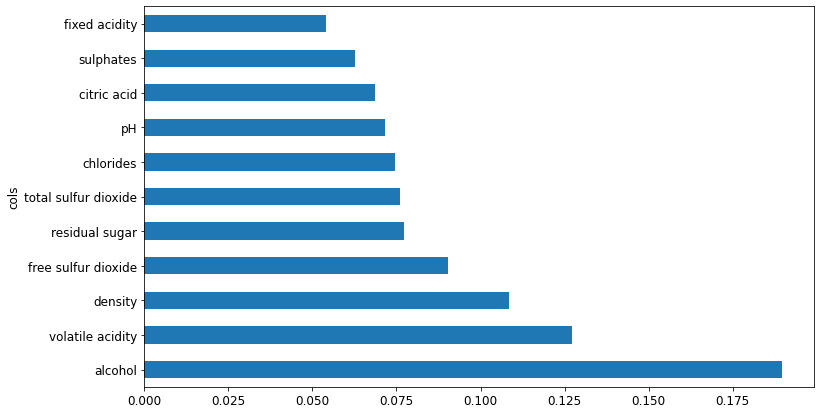

In [116]:
plot_fi(fi_class);

In [117]:
to_class_keep = fi_class[fi_class.imp>0.06].cols
len(to_class_keep)

10

In [118]:
xs_class_imp = xs_class[to_class_keep]
valid_xs_class_imp = valid_xs_class[to_class_keep]

In [119]:
m_class = rf_class(xs_class_imp,y_class);

In [120]:
m_class.score(xs_class_imp, y_class), m_class.score(valid_xs_class_imp, valid_y_class)

(0.73694954797317, 0.6010891763104153)

In [121]:
len(xs_class.columns), len(xs_class_imp.columns)

(11, 10)

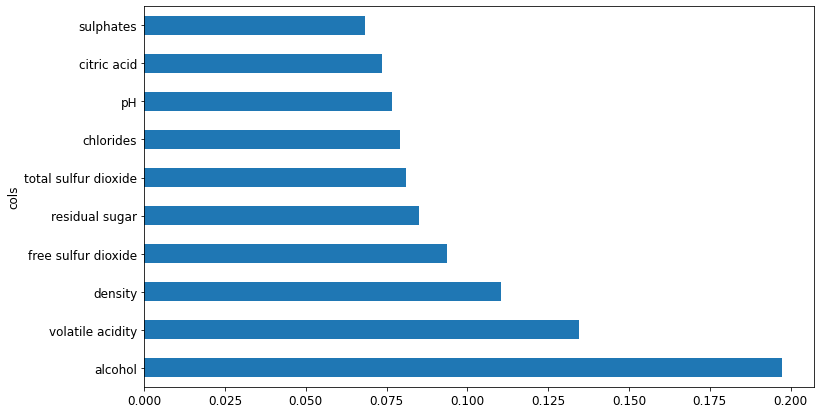

In [122]:
plot_fi(rf_feat_importance(m_class, xs_class_imp));

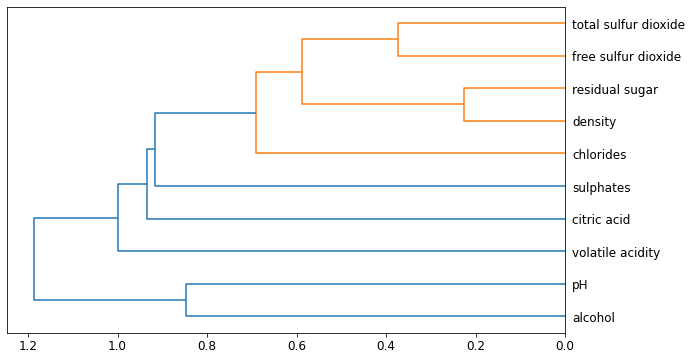

In [123]:
cluster_columns(xs_class_imp)

In [124]:
def get_oob_class(df_class):
    m = RandomForestClassifier(n_jobs=-1, n_estimators=80, oob_score=True)
    m.fit(df_class, y_class)
    return m.oob_decision_function_

In [125]:
get_oob_class(xs_class_imp)

array([[0.        , 0.        , 0.        , ..., 1.        , 0.        , 0.        ],
       [0.        , 0.05714286, 0.31428571, ..., 0.05714286, 0.05714286, 0.        ],
       [0.        , 0.0625    , 0.0625    , ..., 0.5       , 0.125     , 0.        ],
       ...,
       [0.        , 0.03030303, 0.75757576, ..., 0.03030303, 0.        , 0.        ],
       [0.        , 0.        , 0.63636364, ..., 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.03333333, ..., 0.2       , 0.        , 0.        ]])

In [126]:
xs_class_final = xs_class_imp
valid_xs_class_final = valid_xs_class_imp

In [127]:
save_pickle('xs_class_final.pkl', xs_class_final)
save_pickle('valid_xs_class_final.pkl', valid_xs_class_final)

In [128]:
xs_class_final = load_pickle('xs_class_final.pkl')
valid_xs_class_final = load_pickle('valid_xs_class_final.pkl')

In [129]:
m_class = rf_class(xs_class_final, y_class)
m_class.score(xs_class_final, y_class), m_class.score(valid_xs_class_final, valid_y_class)

(0.7357830271216098, 0.6038121170864533)

In [130]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [131]:
row = valid_xs_class_final.iloc[:5]

In [132]:
predictions_class,bias_class,contributions_class = treeinterpreter.predict(m_class, row.values)

In [133]:
predictions_class[0], bias_class[0], contributions_class[0].sum()

(array([0.00435837, 0.01672393, 0.28169617, 0.57416337, 0.10926991, 0.01378825, 0.        ]),
 array([0.00499635, 0.03716171, 0.2918606 , 0.4488065 , 0.18150554, 0.03450933, 0.00115996]),
 -3.9853747201262085e-17)

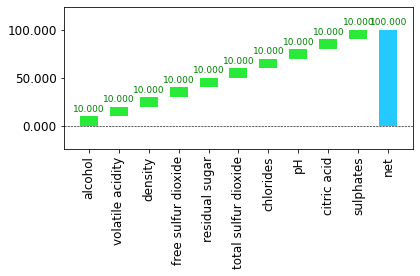

In [134]:
waterfall(valid_xs_class_final.columns, contributions_class[0].argmax(), threshold=0.5,
         rotation_value=90,formatting='{:,.3f}');

In [135]:
df_dom_class = pd.concat([xs_class_final, valid_xs_class_final])
is_valid_class = np.array([0]*len(xs_class_final) + [1]*len(valid_xs_class_final))

In [136]:
m_class = rf_class(df_dom_class, is_valid_class)
rf_feat_importance(m_class, df_dom_class)

,cols,imp
2,density,0.236259
4,residual sugar,0.117532
5,total sulfur dioxide,0.110732
6,chlorides,0.094224
7,pH,0.078200
3,free sulfur dioxide,0.077374
1,volatile acidity,0.074487
8,citric acid,0.071752
9,sulphates,0.071574
0,alcohol,0.067865


In [137]:
m_class = rf_class(xs_class_final, y_class)
print('orig', m_class.score(valid_xs_class_final, valid_y_class))

for c in ('density','residual sugar', 'total sulfur dioxide','total sulfur dioxide'):
    m_class = rf_class(xs_class_final.drop(c, axis=1), y_class)
    print(c, m_class.score(valid_xs_class_final.drop(c, axis=1), valid_y_class))

orig 0.6017699115044248
density 0.6092579986385296
residual sugar 0.6017699115044248
total sulfur dioxide 0.6085772634445201
total sulfur dioxide 0.6085772634445201


In [138]:
t_vars_class = ['density']
xs_class_final_t = xs_class_final.drop(t_vars_class, axis=1)
valid_xs_class_t = valid_xs_class_final.drop(t_vars_class, axis=1)

m_class = rf_class(xs_class_final_t, y_class)
m_class.score(valid_xs_class_t, valid_y_class)

0.6153846153846154

In [139]:
xs_class_filt = xs_class_final_t
y_class_filt = y_class

In [140]:
m_class = rf_class(xs_class_filt, y_class_filt)
m_class.score(xs_class_filt, y_class_filt), m_class.score(valid_xs_class_t, valid_y_class)

(0.7305336832895888, 0.607215793056501)

In [141]:
df_nn_class = pd.read_csv('winequality-white.csv', sep=';', low_memory=False)

In [142]:
df_nn_class_final = df_nn_class[list(xs_class_final_t.columns)+[dep_var_class]]

In [143]:
df_nn_class_final.columns

Index(['alcohol', 'volatile acidity', 'free sulfur dioxide', 'residual sugar',
       'total sulfur dioxide', 'chlorides', 'pH', 'citric acid', 'sulphates',
       'quality'],
      dtype='object')

In [144]:
xs_class_filt2 = xs_class_filt
valid_xs_class_t2 = valid_xs_class_t
m_class2 = rf_class(xs_class_filt2, y_class_filt)
m_class2.score(xs_class_filt2, y_class_filt), m_class2.score(valid_xs_class_t2, valid_y_class)

(0.7249927092446777, 0.6106194690265486)

In [145]:
cont_nn = ['alcohol', 'volatile acidity', 'free sulfur dioxide', 'residual sugar',
       'total sulfur dioxide', 'chlorides', 'pH', 'citric acid', 'sulphates',
       'quality']

In [146]:
to_nn_class = TabularPandas(df_nn_class, procs_class, cont_nn, y_names=dep_var_class, splits=splits_class)

In [147]:
dls_class = to_nn_class.dataloaders(1024)

In [148]:
y_class = to_nn_class.train.y
y_class.min(), y_class.max()

(1, 7)

In [149]:
learn_class = tabular_learner(dls_class, y_range=(3, 9), layers=[500,250])

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.015848932787775993)

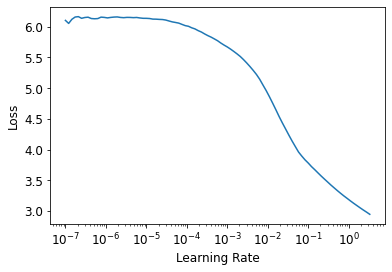

In [150]:
learn_class.lr_find()

In [151]:
learn_class.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,6.114116,5.568045,00:00
1,5.779660,5.587333,00:00
2,5.490298,5.546618,00:00
3,5.242912,5.451771,00:00
4,5.005428,5.311169,00:00
5,4.765763,5.136388,00:00
6,4.527447,5.019224,00:00
7,4.285792,5.040474,00:00
8,4.066109,5.232479,00:00
9,3.878698,5.529403,00:00


In [152]:
preds_nn_class, targs_nn_class = learn_class.get_preds()
accuracy_score(preds_nn_class.argmax(-1), targs_nn_class)

0.0

In [153]:
learn_class.save('nn_class')

Path('models/nn_class.pth')

In [154]:
rf_class_preds = m_class.predict(valid_xs_class_t)
ens_class_preds = (to_np(preds_nn_class.argmax(-1).squeeze()) + rf_class_preds)

In [155]:
accuracy_score(ens_class_preds, valid_y_class)

0.607215793056501